In [36]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

<div class="alert alert-block alert-info">
<h3><center>Approach</center></h3>

- IMDB movie ratings data was downloaded
- the data was explored and cleaned up lightly (only numerical ones to save time) as methods like one-hot encoding categorical ones inflates processing time hugely
- three plots were generated showing the raw data, how the features interact (correlation heatmap), and feature importances after a popular model was trained and tested (Random Forest)
- finally, 10 improvement methods are enumerated at the bottom of the notebook
</div>

<h3><center>To avoid the version and warning issues, we install s3fs here.</center></h3>

In [37]:
!pip install s3fs

<h3><center>Import and explore the data.</center></h3>
 - for instance we can take a look at the data outline, i.e. schema

In [38]:
import s3fs

my_s3_bucket = 's3://mulugetadiproject/movie_data.csv'
movies_df = pd.read_csv(my_s3_bucket)
print('Data shape: \n ', movies_df.shape)
print('Data preview: \n ', movies_df.head(5))
print('Column names: \n ', movies_df.columns)
print('Schema/info: \n ', movies_df.info())

Data shape: 
  (5043, 15)
Data preview: 
     index      director_name  duration      actor_2_name  \
0      0      James Cameron     178.0  Joel David Moore   
1      1     Gore Verbinski     169.0     Orlando Bloom   
2      2         Sam Mendes     148.0      Rory Kinnear   
3      3  Christopher Nolan     164.0    Christian Bale   
4      4        Doug Walker       NaN        Rob Walker   

                            genres     actor_1_name  \
0  Action|Adventure|Fantasy|Sci-Fi      CCH Pounder   
1         Action|Adventure|Fantasy      Johnny Depp   
2        Action|Adventure|Thriller  Christoph Waltz   
3                  Action|Thriller        Tom Hardy   
4                      Documentary      Doug Walker   

                                         movie_title  num_voted_users  \
0                                            Avatar            886204   
1          Pirates of the Caribbean: At World's End            471220   
2                                           Spectre 

<h3><center>Remove columns we do not need for prediction: 'index', 'movie_imdb_link','title_year'.</center></h3>

In [39]:
movies_df = movies_df[['director_name', 'duration', 'actor_2_name', 'genres',
       'actor_1_name', 'movie_title', 'num_voted_users', 'actor_3_name',
       'num_user_for_reviews', 'language', 'country','imdb_score']]

#  to save time, we will use only numerical columns here
cols = movies_df.columns
num_cols = movies_df._get_numeric_data().columns
cat_cols = list(set(cols) - set(num_cols))
print('Numerical Columns: ', num_cols)
print('Categorical Columns: ', cat_cols)
movies_df = movies_df[num_cols]

# check again the size of the data
print('Data shape after removing categorical columns: \n ', movies_df.shape)

Numerical Columns:  Index(['duration', 'num_voted_users', 'num_user_for_reviews', 'imdb_score'], dtype='object')
Categorical Columns:  ['actor_2_name', 'actor_1_name', 'director_name', 'actor_3_name', 'language', 'country', 'movie_title', 'genres']
Data shape after removing categorical columns: 
  (5043, 4)


<h3><center>Light clean up: remove nulls, duplicate values if there are any and:</center></h3>
- explore the data and get column-wise basic statistics
- use average rating and display a table for the top 5 movies

,duration,num_voted_users,num_user_for_reviews,imdb_score
1937,142.0,1689764,4144.0,9.3
3466,175.0,1155770,2238.0,9.2
2824,55.0,12590,37.0,9.1
3207,55.0,12591,37.0,9.1
4409,90.0,246,1.0,9.1


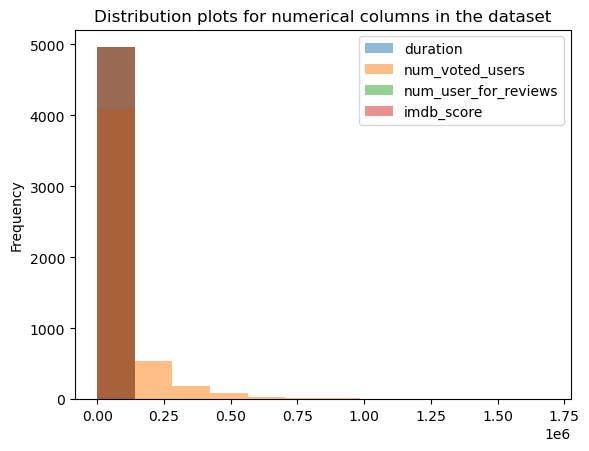

In [40]:
movies_df.dropna(axis=0,inplace=True)
movies_df.drop_duplicates(inplace=True)
movies_df.shape

ax = movies_df.plot.hist(bins=12, alpha=0.5)
ax.set_title('Distribution plots for numerical columns in the dataset')

movies_df[movies_df.columns].sort_values(by='imdb_score', ascending=False).head(5)

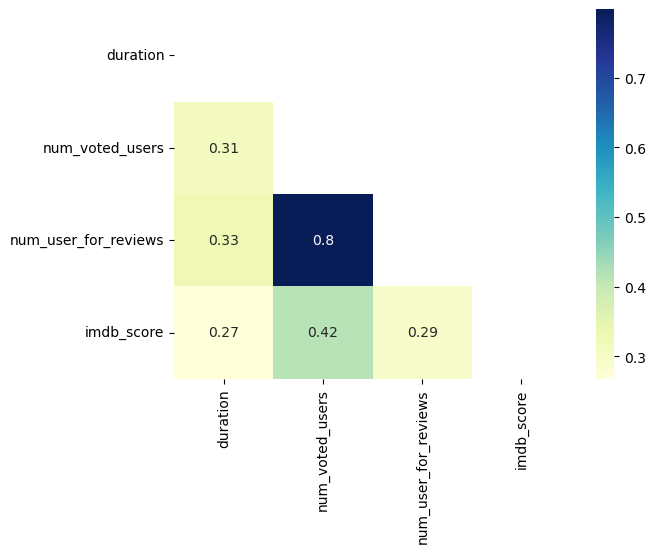

In [41]:
import seaborn as sb

# mask
mask = np.triu(np.ones_like(movies_df.corr()))
# triangle correlation heatmap
dataplot = sb.heatmap(movies_df.corr(), cmap="YlGnBu", annot=True, mask=mask)
# display  heatmap
plt.show()

<h3><center>Split the data for training and testing</center></h3>

In [42]:
X = movies_df.loc[:, movies_df.columns != 'imdb_score']
y = movies_df.imdb_score

X_train, X_test, y_train, y_test= train_test_split(X, y,
                                    test_size=0.3, random_state=100)

<h3><center>Create a random forest regression model and:</center></h3>
- fit
- predict and evaluate for accuracy

In [43]:
model = RandomForestRegressor()

# fit the model
model.fit(X, y)

# predict
y_pred = model.predict(X_test)

# evaluate the model, using predictions
accuracy = model.score(X_test, y_test)

print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 89.27


<h3><center> Explore the data and show llustrate features that impact the average rating of a movie</center></h3>
- also, extract the features that impact the average rating of a movie

In [44]:
importance = model.feature_importances_

# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
std = np.std([model.feature_importances_ for model in model.estimators_],
             axis=0)
indices = np.argsort(importance)

Feature: 0, Score: 0.25646
Feature: 1, Score: 0.48764
Feature: 2, Score: 0.25590


<h3><center>Feature importance plot, bar length shows importance to predicting ratings</center></h3>

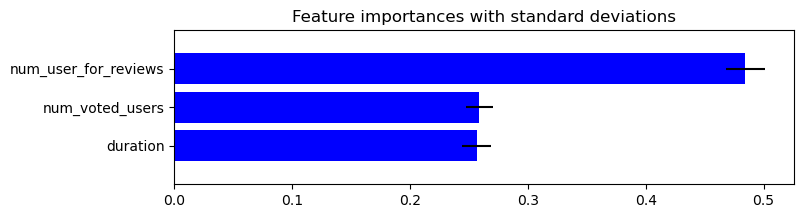

In [26]:
plt.figure(figsize=(8,2))
plt.title("Feature importances with standard deviations")
plt.barh(range(X.shape[1]), importance[indices],
       color="b", xerr=std[indices], align="center")
plt.ylim([-1, X.shape[1]])
plt.yticks(range(len(model.feature_importances_)), X.columns)
plt.show()

<h3><center>Other measures, RMSE and adjusted R-square</center></h3>

In [28]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
n = y_pred.shape[0]
k = X_train.shape[1]
adj_r_sq = 1 - (1 - r2)*(n-1)/(n-1-k)

print(RMSE, r2, adj_r_sq)

0.37835126401160696 0.8918742709120976 0.8916558350957584


<div class="alert alert-block alert-info">
<h3><center>10 things to do to improve the model:</center></h3> 

1. use larger dataset
2. clean the data such as by removing one of two colinear columns
3. remove non-varying columns, such as the language column if it is almost all 'English'
4. remove outliers
5. select only the top few important variables
6. engineer new features by combining some
7. tune the algorithm using its parameters such as cross validation
8. compare models and use ensemble methods
9. one-hot encode categorical data, if any
10. scale features
    
</div>